## Classificação do Fashion MNIST com NN simples e Regressão Logística

Funções das Redes Neurais

In [35]:
'''Criando a funcao de normalização de um dataframe inteiro
    input:
        df: Dataframe
    output:
        df: Dataframe com valores normalizados
'''
def normalize_dataframe(df):
    for column in df:
        df[column] = df[column]/255
    return df


'''Funcao para aplicar relu em um vetor
    input:
        z: weights * params + bias
    output:
        s: 0 para valores negativos z para valores positivos aplicado em cada amostra
'''    
def relu(z):
    return np.maximum(z, 0)


'''Funcao para aplicar a derivada da relu em um vetor
    input:
        z: weights * params + bias
    output:
        s: 0 para valores negativos 1 para valores positivos aplicado em cada amostra
'''    
def relu_(z):
    return np.array(z>0).astype(int)


'''Funcao para aplicar sigmoid em um vetor
    input:
        z: weights * params + bias
    output:
        s: valor entre 0-1 da aplicação da função para cada amostra
'''
def sigmoid(z):
    #print(z.shape)
    s = 1 / (1 + np.exp(-z))
    return s


'''Funcao para aplicar a derivada da sigmoid em um vetor
    input:
        z: weights * params + bias
    output:
        p: taxa de variação da sigmoid para cada amostra
'''
def sigmoid_(z):
    #print(sigmoid(Z1).shape)
    s = sigmoid(z) * (1 - sigmoid(z))
    return s


'''Funcao para calcular a tangente hiporbólica em um vetor
    input:
        x: weights * params + bias
    output:
        s: valor entre 0-1 da aplicação da função para cada amostra
'''
def tanh(x):
    s = (2 / (1 + np.exp(-2*x))) -1
    return s


'''Funcao para calcular a derivada da tangente hiporbólica em um vetor
    input:
        x: weights * params + bias
    output:
        s: porcentagem de chance do valor ser da classe predita para cada amostra
'''
def tanh_(x):
    s = 1 - tanh(x)**2
    return s


'''Funcao para calcular o erro médio da predição utilizando cross-entropy (Não pode ser utilizada com Relu, mas ok na output com softmax)
    input:
        Y: Labels
        Y_pred: Labels Preditas
    output:
        custo: erro médio da predição
'''
def cross_entropy_loss(Y, Y_pred):
    samples_number = Y.shape[1]
    custo = -(1./samples_number) * ( np.sum( np.multiply(np.log(Y_pred),Y) ) + np.sum( np.multiply(np.log(1-Y_pred),(1-Y)) ) )
    return custo


'''Funcao para calcular o erro médio da predição utilizando cross-entropy multiclasse (Não pode ser utilizada com Relu, mas ok na output com softmax)
    input:
        Y: Labels
        Y_pred: Labels Preditas
    output:
        custo: erro médio da predição
'''
def multiclass_cross_entropy_loss(Y, Y_pred):

    aux = np.sum(np.multiply(Y, np.log(Y_pred)))
    samples_number = Y.shape[1]
    custo = -(1/samples_number) * aux

    return custo
    

'''Funcao para calcular a probabilidade de ser de cada classe
    input:
        z: entrada da camada de saída
    output:
        p: probabilidade de ser de cada classe
'''
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=0)

### Preparando os Dados

In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time

df = pd.read_csv("data/fashion-mnist_train.csv")

#Separate the Training DF into Train and Validation
msk = np.random.rand(len(df)) < 0.6 

train_df = df[msk]
validation_df = df[~msk]

Y_train = train_df["label"]
Y_validation = validation_df["label"]

train_df = train_df.loc[:, train_df.columns != "label"]
validation_df = validation_df.loc[:, validation_df.columns != "label"]

#test_df = pd.read_csv("data/fashion-mnist_test.csv")

normalized_train_df = normalize_dataframe(train_df)
normalized_validation_df = normalize_dataframe(validation_df)


#One hot encoding labels para o softmax
classes = 10

samples_train = Y_train.shape[0]
samples_validation = Y_validation.shape[0]

Y_train = np.array(Y_train).reshape(1, samples_train)

y_aux = np.eye(classes)[Y_train.astype('int32')]
y_aux = y_aux.T.reshape(classes, samples_train)
Y_train = y_aux

Y_validation = np.array(Y_validation).reshape(1, samples_validation)

y_aux = np.eye(classes)[Y_validation.astype('int32')]
y_aux = y_aux.T.reshape(classes, samples_validation)

Y_validation = y_aux

### Visualização dos Dados

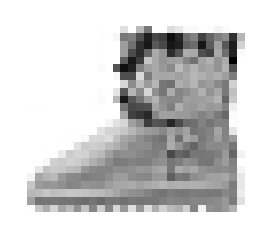

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [12]:
import matplotlib
import matplotlib.pyplot as plt

i = 3
#print(np.array(train_df.iloc[1]).reshape(28,28))
plt.imshow(np.array(train_df.iloc[5]).reshape(28,28), cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()
print(Y_train[:,5])

# 0 	T-shirt/top
# 1 	Trouser
# 2 	Pullover
# 3 	Dress
# 4 	Coat
# 5 	Sandal
# 6 	Shirt
# 7 	Sneaker
# 8 	Bag
# 9 	Ankle boot


### Rede Neural com 1 Camada Escondida (Multi Class)

In [44]:
#ONE HIDDEN LAYER

classes = 10
n_hl = 64
learning_rate = 0.3

X = train_df.T
Y = Y_train

n_x = X.shape[0]
m = X.shape[1]

W1 = np.random.randn(n_hl, n_x) * 0.01
b1 = np.zeros((n_hl, 1))
W2 = np.random.randn(classes, n_hl) *0.01
b2 = np.zeros((classes, 1))

for i in range(2000):

    #Feed forward
    hl_input = np.matmul(W1,X) + b1
    hl_output = sigmoid(hl_input)
    ol_input = np.matmul(W2,hl_output) + b2
    ol_output = softmax(ol_input)

    #Calculate the error
    cost = multiclass_cross_entropy_loss(Y, ol_output)

    #Backpropagation
    d_ol_input = ol_output-Y
    d_W2 = (1./m) * np.matmul(d_ol_input, hl_output.T)
    d_b2 = (1./m) * np.sum(d_ol_input, axis=1, keepdims=True)

    d_hl_output = np.matmul(W2.T, d_ol_input)
    d_hl_input = d_hl_output * sigmoid_(hl_input)
    d_W1 = (1./m) * np.matmul(d_hl_input, X.T)
    d_b1 = (1./m) * np.sum(d_hl_input, axis=1, keepdims=True)

    #Atualização dos pesos e biases
    W2 = W2 - learning_rate * d_W2
    b2 = b2 - learning_rate * d_b2
    W1 = W1 - learning_rate * d_W1
    b1 = b1 - learning_rate * d_b1

    if (i % 100 == 0):
        print("Epoch", i, "cost: ", cost)

print("Final cost:", cost)

Epoch 0 cost:  2.3036250511267475
Epoch 100 cost:  1.245583603756905
Epoch 200 cost:  0.8657819158539172
Epoch 300 cost:  0.71017659759372
Epoch 400 cost:  0.6363448574154088
Epoch 500 cost:  0.5895219238766266
Epoch 600 cost:  0.5552352213388783
Epoch 700 cost:  0.5286422190701621
Epoch 800 cost:  0.5075402877929316
Epoch 900 cost:  0.4905077984538176
Epoch 1000 cost:  0.47644502093151386
Epoch 1100 cost:  0.4645457263638161
Epoch 1200 cost:  0.45426011522976495
Epoch 1300 cost:  0.4452232628286702
Epoch 1400 cost:  0.4371864274035958
Epoch 1500 cost:  0.4299680362699815
Epoch 1600 cost:  0.42342663202140557
Epoch 1700 cost:  0.41744833220934036
Epoch 1800 cost:  0.4119408694793463
Epoch 1900 cost:  0.4068299044569764
Final cost: 0.4021022262800445


In [67]:
from sklearn.metrics import classification_report, confusion_matrix

Z1 = np.matmul(W1, normalized_validation_df.T) + b1
A1 = sigmoid(Z1)
Z2 = np.matmul(W2, A1) + b2
A2 = softmax(Z2)

predictions = np.argmax(A2, axis=0)
labels = np.argmax(Y_validation, axis=0)

print(confusion_matrix(predictions, labels))
print(classification_report(predictions, labels))

ValueError: operands could not be broadcast together with shapes (16,24196) (32,1) 

### Rede Neural com 2 Camadas Escondidas (Multiclasse)

In [76]:
#ONE HIDDEN LAYER

classes = 10
n_hl_1 = 64
n_hl_2 = 64
learning_rate = 0.4

df = train_df.T
Y = Y_train

n_x = df.shape[0]
m = df.shape[1]

weights_1 = np.random.randn(n_hl_1, n_x) * 0.01
b1 = np.zeros((n_hl_1, 1))
weights_2 = np.random.randn(n_hl_2, n_hl_1) *0.01
b2 = np.zeros((n_hl_2, 1))
weights_3 = np.random.randn(classes, n_hl_2) *0.01
b3 = np.zeros((classes, 1))

for i in range(2000):

    #Feed forward
    hl_1_input = np.matmul(weights_1,df) + b1
    hl_1_output = relu(hl_1_input) 
    hl_2_input = np.matmul(weights_2,hl_1_output) + b2
    hl_2_output = relu(hl_2_input)
    ol_input = np.matmul(weights_3,hl_2_output) + b3
    ol_output = softmax(ol_input)

    #Calculate the error
    cost = multiclass_cross_entropy_loss(Y, ol_output)

    #Backpropagation
    d_ol_input = ol_output-Y
    d_weights_3 = (1./m) * np.matmul(d_ol_input, hl_2_output.T)
    d_b3 = (1./m) * np.sum(d_ol_input, axis=1, keepdims=True)
    
    d_hl_2_output = np.matmul(weights_3.T, d_ol_input)
    d_hl_2_input = d_hl_2_output * relu_(hl_2_input)
    d_weights_2 = (1./m) * np.matmul(d_hl_2_input, hl_1_output.T)
    d_b2 = (1./m) * np.sum(d_hl_2_input, axis=1, keepdims=True)

    d_hl_1_output = np.matmul(weights_2.T, d_hl_2_input)
    d_hl_1_input = d_hl_1_output * relu_(hl_1_input)
    d_weights_1 = (1./m) * np.matmul(d_hl_1_input, df.T)
    d_b1 = (1./m) * np.sum(d_hl_1_input, axis=1, keepdims=True)

    #Atualização dos pesos e biases
    weights_3 = weights_3 - learning_rate * d_weights_3
    b3 = b3 - learning_rate * d_b3
    weights_2 = weights_2 - learning_rate * d_weights_2
    b2 = b2 - learning_rate * d_b2
    weights_1 = weights_1 - learning_rate * d_weights_1
    b1 = b1 - learning_rate * d_b1

    if (i % 100 == 0):
        print("Epoch", i, "cost: ", cost)

print("Final cost:", cost)

Epoch 0 cost:  2.302549660265978
Epoch 100 cost:  2.195334733023653
Epoch 200 cost:  1.1619762652462717
Epoch 300 cost:  0.8131110830503772
Epoch 400 cost:  0.6411048256936106
Epoch 500 cost:  0.5474594263480588
Epoch 600 cost:  0.5306064928346175
Epoch 700 cost:  0.5092909280294695
Epoch 800 cost:  0.4532357925252109
Epoch 900 cost:  0.4286813327062372
Epoch 1000 cost:  0.39472363794750415
Epoch 1100 cost:  0.44625788917048936
Epoch 1200 cost:  0.3856313005201653
Epoch 1300 cost:  0.36506972377102165
Epoch 1400 cost:  0.3964792644353302
Epoch 1500 cost:  0.3650909233731397
Epoch 1600 cost:  0.3487465770139985
Epoch 1700 cost:  0.35048209766329125
Epoch 1800 cost:  0.39848935299425026
Epoch 1900 cost:  0.3341025107260855
Final cost: 0.3230119799774802


In [77]:
from sklearn.metrics import classification_report, confusion_matrix

Z1 = np.matmul(weights_1, normalized_validation_df.T) + b1
A1 = relu(Z1)
Z2 = np.matmul(weights_2, A1) + b2
A2 = relu(Z2)
Z3 = np.matmul(weights_3, A2) + b3
A3 = softmax(Z3)

predictions = np.argmax(A3, axis=0)
labels = np.argmax(Y_validation, axis=0)

print(confusion_matrix(predictions, labels))
print(classification_report(predictions, labels))

[[2076    5   34   45    2    2  390    0   11    0]
 [   7 2304    2   17    1    0    3    0    2    0]
 [  37    6 1754   11  116    0  210    0   15    0]
 [ 154   68   33 2240   97    1  114    0   21    0]
 [   7   10  409  105 2083    0  223    0   18    0]
 [   1    0    0    0    0 2271    1   69   10   27]
 [ 175    0  136   42  165    1 1441    0   19    0]
 [   0    0    0    0    0   53    0 2120    3   35]
 [  26    2   11    3   11    7   25    5 2352    1]
 [   0    0    0    0    0   42    0  231    0 2278]]
             precision    recall  f1-score   support

          0       0.84      0.81      0.82      2565
          1       0.96      0.99      0.97      2336
          2       0.74      0.82      0.77      2149
          3       0.91      0.82      0.86      2728
          4       0.84      0.73      0.78      2855
          5       0.96      0.95      0.96      2379
          6       0.60      0.73      0.66      1979
          7       0.87      0.96      0.91  